# RNN - Sequence model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from d2l import torch as d2l
from math import ceil, floor, pi
from torch import nn

In [2]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

In [3]:
data = pd.read_csv('../data/Phuket.csv')

In [4]:
times = data['time'].to_numpy()

In [5]:
events = np.zeros(int(ceil(np.max(times))))
for i in range(0, len(times)):
    index = int(floor(times[i]))
    events[index] = events[index] + 1

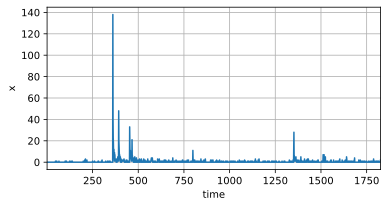

In [6]:
T = len(events)
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.from_numpy(events.astype(np.float32))
d2l.plot(time, [x], 'time', 'x', xlim=[1, T], figsize=(6, 3))

In [7]:
tau = 100
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 1200
train_iter = d2l.load_array((features[:n_train,:], labels[:n_train]), batch_size, is_train=True)

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [9]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 20.122114
epoch 2, loss: 18.485931
epoch 3, loss: 17.743214
epoch 4, loss: 17.285402
epoch 5, loss: 17.057597
epoch 6, loss: 17.102221
epoch 7, loss: 17.014164
epoch 8, loss: 17.047032
epoch 9, loss: 16.617254
epoch 10, loss: 16.487186


In [10]:
onestep_preds = net(features)

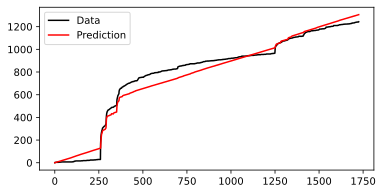

In [11]:
plt.plot(np.cumsum(events[tau:]), 'k', label='Data')
plt.plot(np.cumsum(onestep_preds.detach().numpy()), 'r', label='Prediction')
plt.legend()

In [12]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

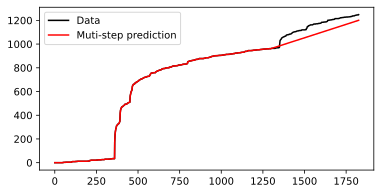

In [13]:
plt.plot(np.cumsum(events), 'k', label='Data')
plt.plot(np.cumsum(multistep_preds.detach().numpy()), 'r', label='Muti-step prediction')
plt.legend()

In [14]:
steps = [1, 4, 16, 64]
predictions = torch.zeros((T, len(steps)))
for count, step in enumerate(steps):
    for i in range(tau, T - step):
        multistep_preds = torch.zeros(T)
        multistep_preds[: i] = x[: i]
        for j in range(i, i + step):
            multistep_preds[j] = net(multistep_preds[j - tau:j].reshape((1, -1)))
        predictions[i, count] = multistep_preds[i + step - 1]

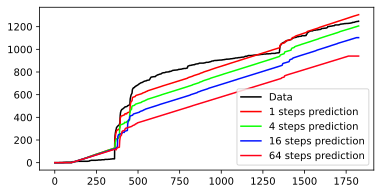

In [15]:
cmap = get_cmap(len(steps))
plt.plot(np.cumsum(events), 'k', label='Data')
for count, step in enumerate(steps):
    plt.plot(np.cumsum(predictions[:, count].detach().numpy()), color=cmap(count), label=str(step) + ' steps prediction')
plt.legend()

# Implementation of RNN

In [16]:
def get_params(M, num_hiddens):
    num_inputs = num_outputs = 2 * M

    def normal(shape):
        return torch.randn(size=shape) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [17]:
def init_rnn_state(batch_size, num_hiddens):
    return torch.zeros((batch_size, num_hiddens))

In [18]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `M`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H = state
    outputs = []
    # Shape of `X`: (`batch_size`, `M`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), H

In [19]:
def encoding(X, M):
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    num_steps, batch_size = X.T.shape
    res = torch.zeros((num_steps, batch_size, 2 * M))
    t = np.arange(0, num_steps).astype(np.float32)
    for k in range(1, M + 1):
        basis_func_C = torch.from_numpy(np.cos(2 * pi * k * t / num_steps).astype(np.float32))
        basis_func_S = torch.from_numpy(np.sin(2 * pi * k * t / num_steps).astype(np.float32))
        for i in range(0, batch_size):
            weight_C = torch.dot(X[i, :], basis_func_C)
            weight_S = torch.dot(X[i, :], basis_func_S)
            res[:, i, 2 * k - 1] = weight_C * basis_func_C
            res[:, i, 2 * k - 2] = weight_S * basis_func_S
    return res

In [20]:
class RNNModelScratch:
    def __init__(self, M, num_hiddens, get_params, init_state, forward_fn):
        self.M, self.num_hiddens = M, num_hiddens
        self.params = get_params(M, num_hiddens)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = encoding(X, M)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [21]:
num_hiddens = 512
M = 5
net = RNNModelScratch(M, num_hiddens, get_params, init_rnn_state, rnn)
state = net.begin_state(features[:n_train,:].shape[0])
Y, new_state = net(features[:n_train,:], state)
Y.shape, len(new_state), new_state.shape

(torch.Size([120000, 10]), 1200, torch.Size([1200, 512]))

In [22]:
def predict(features, num_preds, net, M, n_warm):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1)
    outputs = [encoding(features[:, 0], M)]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for i in range(1, n_warm):
        _, state = net(features[:, :i], state)
        outputs.append(encoding(features[:, i], M))
    for i in range(n_warm, n_warm + num_preds):
        y, state = net(features[:, :i], state)
        outputs.append(encoding(features[:, i], M))
    return outputs

In [23]:
outputs = predict(features[:n_train, :], 1, net, M, 50)

In [24]:
outputs[-1].shape

torch.Size([1, 1200, 10])